## Advanced Machine Learning
### Practical 1 - Transfer Learning

In this exercise we will try training a model on image classification with a small dataset. Then we'll try and improve the performance using transfer learning with help from a larger, more generic dataset.

In the first half, you'll implement the basic pre-training / fine-tuning scheme yourself, though I've provided a few helper functions to get started.

In the second half, you'll run an experiment to analyse the performance of your transfer method under different conditions, and produce a short report with a few plots to show what you have found.

#### How to run this practical

I have not tested it on CPU - we are working with (somewhat) deep neural networks, and a GPU is recommended.
If you don't have one on your machine, you can download this notebook and upload it to [Colab](https://colab.research.google.com/) or [Kaggle](https://www.kaggle.com/code) to use their GPU resources.


In [1]:
# if you haven't already, set up the environment:
!pip install torch torchvision numpy scipy matplotlib pandas pillow tqdm

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
import copy

#### Task

You are trying to **maximise the validation accuracy** on a small "target" dataset.
For this we will use a subset of CIFAR-100. This dataset has many classes, but you will pick a group of them as your chosen target domain.

In all cases, the images are 32x32 pixels in RGB colour.

Below we load CIFAR-100 and create the subset of your choosing.

In [3]:
### download cifar-100 as torchvision dataset:

cifar100 = datasets.CIFAR100(root='data/', download=True)
cifar100.name, cifar100.num_classes = 'CIFAR-100', len(cifar100.classes)
print(f'{cifar100.name}: {len(cifar100)} samples')

100%|██████████| 169001437/169001437 [00:04<00:00, 34033223.63it/s]


Extracting data/cifar-100-python.tar.gz to data/
CIFAR-100: 50000 samples


CIFAR-100's 100 classes are split across 20 coarse 'superclasses'. To create your small target dataset, pick one of these superclasses below:

In [4]:
cifar_superclasses = {
   "aquatic mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
              "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
           "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
   "food containers": ["bottle", "bowl", "can", "cup", "plate"],
     "fruit and veg": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
       "electricals": ["clock", "keyboard", "lamp", "telephone", "television"],
         "furniture": ["bed", "chair", "couch", "table", "wardrobe"],
           "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
  "large carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
   "large buildings": ["bridge", "castle", "house", "road", "skyscraper"],
    "natural scenes": ["cloud", "forest", "mountain", "plain", "sea"],
  "large herbivores": ["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
    "medium mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
     "invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
            "people": ["baby", "boy", "girl", "man", "woman"],
          "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
     "small mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
             "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
          "vehicles": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "weird vehicles": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"]
}

# choose your favourite:
TARGET_CATEGORY = "reptiles"

In [5]:
### create the subset

superclass_names = cifar_superclasses[TARGET_CATEGORY]

superclass_idxs = set([cifar100.class_to_idx[n] for n in superclass_names])
subset_idxs = [i for i,idx in enumerate(cifar100.targets) if idx in superclass_idxs]
target_data = torch.utils.data.Subset(cifar100, subset_idxs)
# since we are removing classes, we must remap the indexes to the correct range:
target_data.remap = {cifar100.class_to_idx[name]: i for i,name in enumerate(superclass_names)}
old_targets = [label for img,label in target_data]
target_data.labels = [target_data.remap[t] for t in old_targets]
target_data.classes = superclass_names
target_data.num_classes = len(superclass_names)

target_data.name = f'CIFAR-{TARGET_CATEGORY.capitalize()}'

print(f'{target_data.name}: {len(target_data)} samples')
print(' =Classes=')
super_label_counts = np.unique(target_data.labels, return_counts=True)[1]
for c, name in enumerate(target_data.classes):
    num_samples = super_label_counts[c]
    print(f'  {c}: {name:<10} ({num_samples} samples)')

CIFAR-Reptiles: 2500 samples
 =Classes=
  0: crocodile  (500 samples)
  1: dinosaur   (500 samples)
  2: lizard     (500 samples)
  3: snake      (500 samples)
  4: turtle     (500 samples)


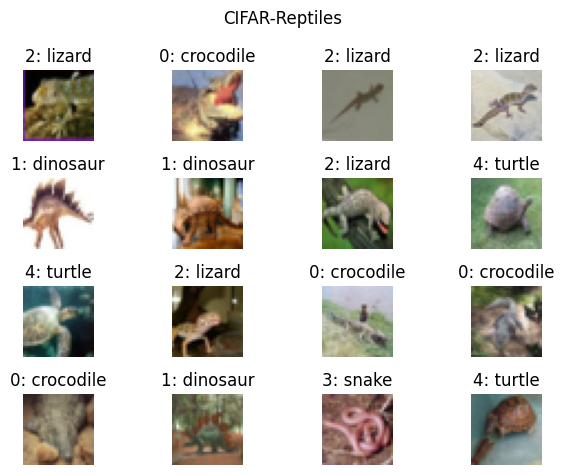

In [6]:
### examine a few of the images:

def inspect_data(data, layout=(4,4)):
    """accepts a training or validation subset
    and plots images from the data with class annotations"""
    num_examples = np.prod(layout)
    example_idxs = np.random.choice(range(len(data)), num_examples, replace=False)
    examples = [data[i] for i in example_idxs]

    # correct for label remapping:
    if 'remap' not in dir(data):
        original_set = data.dataset
    else:
        original_set = data

    # iterate through axes and plot individual examples:
    i = 0
    fig, axes = plt.subplots(*layout)
    for r, row in enumerate(axes):
        for c, ax in enumerate(row):
            image, label = examples[i]
            if 'classes' in dir(original_set):
                if 'remap' in dir(original_set):
                    label = original_set.remap[label]
                label = f'{label}: {original_set.classes[label]}'
            ax.imshow(image)
            # tidy up axis:
            ax.set_title(label)
            ax.set_axis_off()
            i += 1
    fig.suptitle(original_set.name)
    fig.tight_layout()

    plt.show()

inspect_data(target_data)

In [7]:
### we create a training and validation split here,
### and your objective is to maximise the accuracy
### on this validation split.

VAL_FRAC = 0.2
torch.manual_seed(0)
train_data_target, val_data_target = torch.utils.data.random_split(target_data, [1-VAL_FRAC, VAL_FRAC])

for split, name in zip([train_data_target, val_data_target],
                       ['train', 'validation']):
    print(f'{name} split: {len(split)} examples')


train split: 2000 examples
validation split: 500 examples


In [8]:
### to perform initial (baseline) training on this data,
### we define a simple model, nothing too fancy

class BasicCNN(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2) # after first two conv layers

        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))

        x = x.view(-1, 128 * 8 * 8) # reshape to vector
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.classifier(x)

        return x

In [9]:
### a couple of helper functions for showing loss/accuracy:

def training_plot(metrics,
      sep=None, # optional: number of steps at which to draw separator line
      alpha=0.05, # smoothing parameter for train loss
      ):

    train_losses, val_losses, train_accs, val_accs, epoch_steps = metrics

    fig, (loss_ax, acc_ax) = plt.subplots(1,2)

    ### plot loss:
    smooth_train_loss = pd.Series(train_losses).ewm(alpha=alpha).mean()
    steps = np.arange(0, len(train_losses))

    # train loss is plotted at every step:
    loss_ax.plot(steps, smooth_train_loss, 'b-', label='train loss')
    # but val loss is plotted at every epoch:
    loss_ax.plot(epoch_steps, val_losses, 'r-', label='val loss')

    loss_ax.legend(); loss_ax.set_xlabel('Training step'); loss_ax.set_ylabel('Loss (CXE)')


    ### plot acc:
    smooth_train_acc = pd.Series(train_accs).ewm(alpha=0.05).mean()

    acc_ax.plot(steps, smooth_train_acc, 'b-', label='train acc')
    acc_ax.plot(epoch_steps, val_accs, 'r-', label='val acc')

    acc_ax.legend(); acc_ax.set_xlabel('Training step'); acc_ax.set_ylabel('Accuracy')

    # format as percentage on right:
    #acc_ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))
    acc_ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.05))
    acc_ax.yaxis.tick_right()
    acc_ax.yaxis.set_label_position('right')

    # show a switching point if provided:
    if sep is not None:
        loss_ax.axvline(sep, c='gray', linestyle=':')
        acc_ax.axvline(sep, c='gray', linestyle=':')

    plt.tight_layout()
    plt.show()

def get_batch_acc(pred, y):
    """calculates accuracy over a batch as a float
    given predicted logits 'pred' and integer targets 'y'"""
    return (pred.argmax(axis=1) == y).float().mean().item()

epoch:19 | loss: 0.16|1.89, acc: 96%|57%: 100%|█████████████████████| 20/20 [00:20<00:00,  1.02s/it]


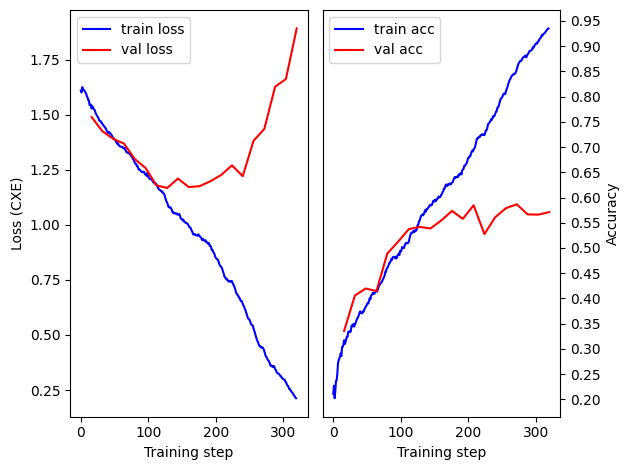

In [10]:
### BASELINE TRAINING

# training hyperparameters:

num_epochs = 20
lr = 1e-3
l2_reg = 1e-3
batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# (but cuda is strongly recommended)

# set up image preprocessing and dataloaders:

pre_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
def collate_target(batch):
    images = [b[0] for b in batch]
    # in this case we require the target domain class remapping:
    labels = [target_data.remap[b[1]] for b in batch]

    image_tensor = torch.stack([pre_transform(img) for img in images])
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return image_tensor, label_tensor

train_loader_target = torch.utils.data.DataLoader(
    train_data_target,
    collate_fn = collate_target,
    batch_size = batch_size,
    shuffle=True)
val_loader_target = torch.utils.data.DataLoader(
    val_data_target,
    collate_fn = collate_target,
    batch_size = batch_size,
    shuffle=True)

# create model:
model = BasicCNN(num_classes=target_data.num_classes).to(device)

# define loss and optimiser:
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)

# track metrics for plotting training curves:
train_losses, train_accs = [], []
val_losses, val_accs = [], []
epoch_steps = [] # used for plotting val loss at the correct x-position
metrics = [train_losses, val_losses, train_accs, val_accs, epoch_steps]

# the dataset is small and trains very fast,
# so we plot progress at the epoch level,
# instead of the usual batch level:
epoch_bar = tqdm(range(num_epochs), ncols=100)

steps_trained = 0
for e in epoch_bar:
    model.train() # set training mode

    epoch_train_losses, epoch_train_accs = [], []
    for batch in train_loader_target:
        x, y = batch
        x, y = x.to(device), y.to(device)

        opt.zero_grad()

        pred = model(x)
        batch_loss = loss_func(pred, y)
        batch_acc = get_batch_acc(pred, y)

        batch_loss.backward()
        opt.step()

        # track loss and accuracy:
        epoch_train_losses.append(batch_loss.item())
        epoch_train_accs.append(batch_acc)
        steps_trained += 1

    epoch_steps.append(steps_trained)

    # record training metrics, by batch and over the epoch:
    train_losses.extend(epoch_train_losses)
    train_accs.extend(epoch_train_accs)

    # evaluate after each epoch::
    with torch.no_grad():
        model.eval() # set eval mode

        batch_val_losses, batch_val_accs = [], []

        # loop over validation set and average the metrics:
        for batch in val_loader_target:
            vx, vy = batch
            vx, vy = vx.to(device), vy.to(device)
            vpred = model(vx)
            val_loss = loss_func(vpred, vy)
            val_acc = get_batch_acc(vpred, vy)

            batch_val_losses.append(val_loss.item())
            batch_val_accs.append(val_acc)
        val_losses.append(np.mean(batch_val_losses))
        val_accs.append(np.mean(batch_val_accs))

    epoch_bar.set_description(f'epoch:{e} | loss: {np.mean(epoch_train_losses):.2f}|{val_losses[-1]:.2f}, acc: {np.mean(epoch_train_accs):.0%}|{val_accs[-1]:.0%}')

# plot training curves:
training_plot(metrics)

Save this plot for your report. This is the baseline performance on our target dataset. It overfits a lot and gets a **validation accuracy of around 60%**, which is not that good.

The main reason for bad generalisation is because the dataset is very small, with only 400 training examples per class (plus another 100 we reserved for validation).

You could try to improve this baseline with some hyperparameter tuning (e.g. more regularization, or altering the network architecture), but it is not the point of this exercise.

Your job is to **improve this number** by using **transfer learning**.

For this, we'll use help from a 'source' domain: the full dataset of CIFAR-10, which has images of the same resolution in a range of categories. These categories are not as specific as in CIFAR-100, but there is a lot of data and it should learn some useful patterns.

100%|██████████| 170498071/170498071 [00:03<00:00, 47477756.19it/s]


Extracting data/cifar-10-python.tar.gz to data/
CIFAR-10: 50000 samples
 =Classes=
  0: airplane   (5000 samples)
  1: automobile (5000 samples)
  2: bird       (5000 samples)
  3: cat        (5000 samples)
  4: deer       (5000 samples)
  5: dog        (5000 samples)
  6: frog       (5000 samples)
  7: horse      (5000 samples)
  8: ship       (5000 samples)
  9: truck      (5000 samples)
train split: 40000 examples
validation split: 10000 examples


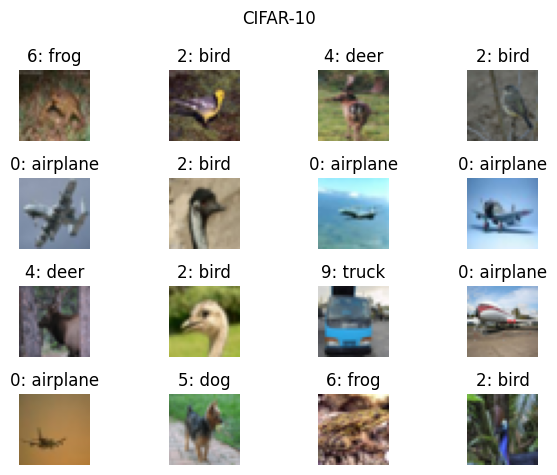

In [11]:
### download the CIFAR-10 data:

cifar10 = datasets.CIFAR10(root='data/', download=True)
cifar10.name, cifar10.num_classes = 'CIFAR-10', len(cifar10.classes)
print(f'{cifar10.name}: {len(cifar10)} samples')
cifar10_labels = np.asarray([x[1] for x in cifar10])
cifar10_label_counts = np.unique(cifar10_labels, return_counts=True)[1]


print(' =Classes=')
for c, name in enumerate(cifar10.classes):
    num_samples = cifar10_label_counts[c]
    print(f'  {c}: {name:<10} ({num_samples} samples)')

### create a training/validation split:

torch.manual_seed(0)
source_data = cifar10
train_data_source, val_data_source = torch.utils.data.random_split(source_data, [1-VAL_FRAC, VAL_FRAC])

for split, name in zip([train_data_source, val_data_source],
                       ['train', 'validation']):
    print(f'{name} split: {len(split)} examples')

inspect_data(train_data_source)

In [12]:
### I've also set up the data loaders here to save time:

def collate_source(batch):
    images = [b[0] for b in batch]
    labels = [b[1] for b in batch]

    image_tensor = torch.stack([pre_transform(img) for img in images])
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return image_tensor, label_tensor

train_loader_source = torch.utils.data.DataLoader(
    train_data_source,
    collate_fn = collate_source,
    batch_size = batch_size,
    shuffle=True)
val_loader_source = torch.utils.data.DataLoader(
    val_data_source,
    collate_fn = collate_source,
    batch_size = batch_size,
    shuffle=True)

## Task 1

Implement a pre-training / fine-tuning scheme by first training on the source domain (CIFAR-10), and then continuing to train on your chosen target domain.

See if you can get the target validation accuracy higher than in the basic setting.

#### Pre-training

* You can re-use the code you've seen so far. Wrap it into functions if it helps.

* You can experiment with altering the basic model architecture, though it's not required for this exercise. Finding good hyperparameters is up to you.

* I recommend saving your pre-trained model after it has converged, so that you can instantiate a separate model for fine-tuning, instead of continuing to train on the same object.
  * But be careful with namespace errors - things can get hairy if you have multiple model objects defined and you are copying code around. Just be sure that the correct data is being run through the correct model, feeding the correct optimiser and logging to the correct plots.

#### Fine-tuning

* Remember that your target data and the source data have different numbers of classes. This will cause errors. You can figure it out.

* It can be helpful to set different hyperparameters for fine-tuning - for example, a lower learning rate.

* You'll probably need to look up some things - this is fine, but avoid using AI assistants like ChatGPT. The point is to write the code so you understand the implementation, rather than copy-pasting existing solutions. (if you're really stuck, ask me instead)


### Task 1 Assessment

* Report your results with **a couple plots** comparing:
  - the target domain performance from the baseline earlier (no transfer)
    
  - the target domain performance with fine-tuning
    
* Also write **a few sentences** summarising any particular issues you ran into, how you solved them, and any insights you gained about the transfer learning process or implementation.

In [13]:
pt_model = BasicCNN(num_classes = source_data.num_classes).to(device)


100%|██████████| 20/20 [04:32<00:00, 13.64s/it]


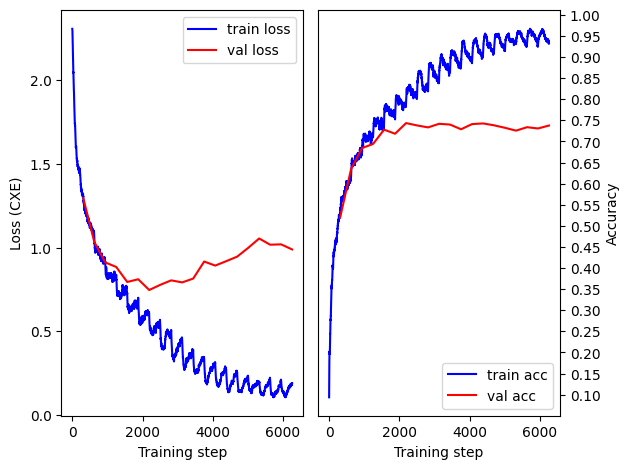

In [14]:
from tqdm import tqdm
### pre-training
pt_model = BasicCNN(num_classes = source_data.num_classes).to(device)

# define loss and optimiser:
loss_func = nn.CrossEntropyLoss()
pt_opt = torch.optim.Adam(pt_model.parameters(), lr=lr, weight_decay=l2_reg)

# pre-training goes here:

num_pt_epochs = 20

# track metrics for plotting training curves:
train_losses, train_accs = [], []
val_losses, val_accs = [], []
epoch_steps = []
pt_metrics = [train_losses, val_losses, train_accs, val_accs, epoch_steps]
steps_trained = 0
for e in tqdm(range(num_pt_epochs)):
    pt_model.train() # set training mode

    epoch_train_losses, epoch_train_accs = [], []
    for batch in train_loader_source:
        x, y = batch
        x, y = x.to(device), y.to(device)

        pt_opt.zero_grad()

        pred = pt_model(x)
        batch_loss = loss_func(pred, y)
        batch_acc = get_batch_acc(pred, y)

        batch_loss.backward()
        pt_opt.step()

        # track loss and accuracy:
        epoch_train_losses.append(batch_loss.item())
        epoch_train_accs.append(batch_acc)
        steps_trained += 1

    epoch_steps.append(steps_trained)

    # record training metrics, by batch and over the epoch:
    train_losses.extend(epoch_train_losses)
    train_accs.extend(epoch_train_accs)

    # evaluate after each epoch:
    with torch.no_grad():
        pt_model.eval() # set eval mode

        batch_val_losses, batch_val_accs = [], []

        # loop over validation set and average the metrics:
        for batch in val_loader_source:
            vx, vy = batch
            vx, vy = vx.to(device), vy.to(device)
            vpred = pt_model(vx)
            val_loss = loss_func(vpred, vy)
            val_acc = get_batch_acc(vpred, vy)

            batch_val_losses.append(val_loss.item())
            batch_val_accs.append(val_acc)
        val_losses.append(np.mean(batch_val_losses))
        val_accs.append(np.mean(batch_val_accs))

    epoch_bar.set_description(f'epoch:{e} | loss: {np.mean(epoch_train_losses):.2f}|{val_losses[-1]:.2f}, acc: {np.mean(epoch_train_accs):.0%}|{val_accs[-1]:.0%}')


# after pre-training, I recommend to save the model checkpoint:
torch.save(pt_model.state_dict(), 'pretrained_model.pt')

# and plot training curves:
training_plot(pt_metrics)

<ipython-input-15-16a3da487932>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('pretrained_model.pt')
100%|██████████| 30/30 [00:20<00:00,  1.

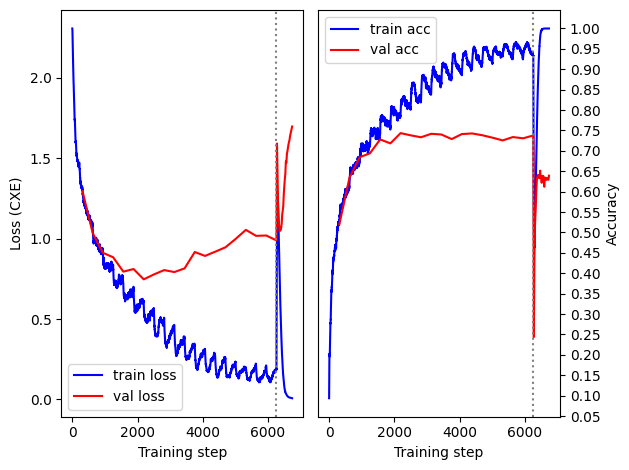

In [15]:
### fine-tuning

# fine-tuning goes here:
ft_model = BasicCNN(num_classes = target_data.num_classes).to(device)

# Load the pretrained state dictionary
pretrained_dict = torch.load('pretrained_model.pt')

# Get the state dictionary of the fine-tuning model
ft_model_dict = ft_model.state_dict()

# Filter out the classifier weights from the pretrained dictionary
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in ft_model_dict and "classifier" not in k}

# Update the fine-tuning model's state dictionary with the filtered pretrained weights
ft_model_dict.update(pretrained_dict)

# Load the updated state dictionary into the fine-tuning model
ft_model.load_state_dict(ft_model_dict)

ft_model.classifier = nn.Linear(256, target_data.num_classes).to(device)

# Initialize the new classifier weights (optional but recommended)
nn.init.kaiming_normal_(ft_model.classifier.weight)
ft_model.classifier.bias.data.fill_(0.01)


# define loss and optimiser:
loss_func = nn.CrossEntropyLoss()
ft_opt = torch.optim.Adam(ft_model.parameters(), lr=lr/10, weight_decay=l2_reg)

num_ft_epochs = 30

# it might be interesting to plot the fine-tuning metrics
# as a continuation of the pre-training ones:
ft_metrics = copy.deepcopy(pt_metrics)
train_losses, val_losses, train_accs, val_accs, epoch_steps = ft_metrics

for e in tqdm(range(num_ft_epochs)):
    ft_model.train() # set training mode
    epoch_train_losses, epoch_train_accs = [], []
    epoch_val_losses, epoch_val_accs = [], []
    for batch in train_loader_target:
        x, y = batch
        x, y = x.to(device), y.to(device)

        ft_opt.zero_grad()

        pred = ft_model(x)
        batch_loss = loss_func(pred, y)
        batch_acc = get_batch_acc(pred, y)

        batch_loss.backward()
        ft_opt.step()

        # track loss and accuracy:
        epoch_train_losses.append(batch_loss.item())
        epoch_train_accs.append(batch_acc)
        steps_trained += 1

    epoch_steps.append(steps_trained)

    # record training metrics, by batch and over the epoch:
    train_losses.extend(epoch_train_losses)
    train_accs.extend(epoch_train_accs)

    # evaluate after each epoch:
    with torch.no_grad():
        ft_model.eval() # set eval mode

        batch_val_losses, batch_val_accs = [], []

        # loop over validation set and average the metrics:
        for batch in val_loader_target:
            vx, vy = batch
            vx, vy = vx.to(device), vy.to(device)
            vpred = ft_model(vx)
            val_loss = loss_func(vpred, vy)
            val_acc = get_batch_acc(vpred, vy)

            batch_val_losses.append(val_loss.item())
            batch_val_accs.append(val_acc)
        val_losses.append(np.mean(batch_val_losses))
        val_accs.append(np.mean(batch_val_accs))

    epoch_bar.set_description(f'epoch:{e} | loss: {np.mean(epoch_train_losses):.2f}|{val_losses[-1]:.2f}, acc: {np.mean(epoch_train_accs):.0%}|{val_accs[-1]:.0%}')


# plot training curves, including the switch from PT to FT:
num_pt_steps = len(pt_metrics[0])
training_plot(ft_metrics, sep=num_pt_steps)

## Task 2

Hopefully you have a good result, and have demonstrated it is possible to improve test performance on a small dataset by exploiting information from another domain.

Now you will build on this by running a small experiment on some different transfer scenarios and reporting your results.

**Choose one** of the following:

- Compare the transfer boost when freezing different layers of your model before fine-tuning. You could try first freezing all of them, then all but the last layer, then all but the second-last, and so on.

- Compare the transfer boost with different network architectures: e.g. try increasing the depth and width of your network and see how the overall behaviour changes with model capacity. (be sure to choose good training hyperparameters as you change the architecture)

- Compare the transfer boost when training with different ratios of source to target data. In our case, we started at 20:1 - you could try 10:1, 5:1, and so on.

- Fix an appropriate 'compute budget' (e.g. 1000 steps) and compare the transfer boost when spending different percentages of this budget on pre-training and fine-tuning respectively (instead of training to convergence). You could try 90-10%, 80-20%, and so on.

- If you have another appropriate idea for an experiment, let me know and you can probably do it.

### Task 2 Assessment

- In each case, you should report your results with **a plot or two**, and **a few sentences** summarising your findings, as well as any technical details you found interesting.

- In the end, your report should be **less than a page**. You should **submit the code** of your finished notebook as well. But don't worry too much about making it look tidy.

- If you were not able to get good-looking results, or could not finish in time, don't worry much. The report will be graded acceptably if you demonstrate an understanding of the transfer process and a sensible approach to the experiment, even if it's not fully complete.

<ipython-input-16-e27a4abae4a7>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('pretrained_model.pt')


Fine-tuning with freeze depth: 0


epoch:19 | loss: 0.02|1.45, acc: 100%|67%: 100%|████████████████████| 20/20 [00:13<00:00,  1.43it/s]


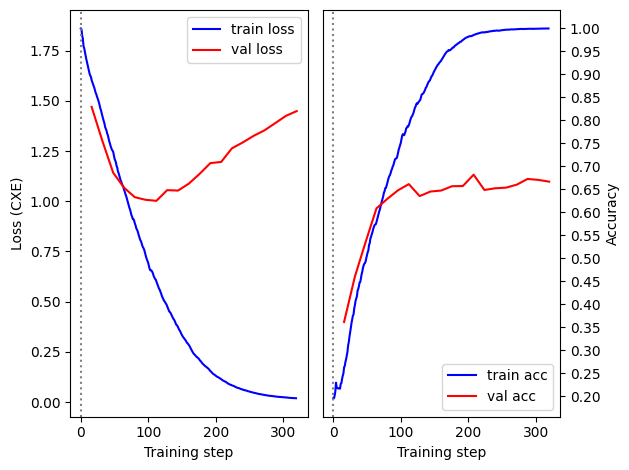

Layers finetuned:12/12
Fine-tuning with freeze depth: 1


epoch:19 | loss: 0.02|1.49, acc: 100%|65%: 100%|████████████████████| 20/20 [00:13<00:00,  1.53it/s]


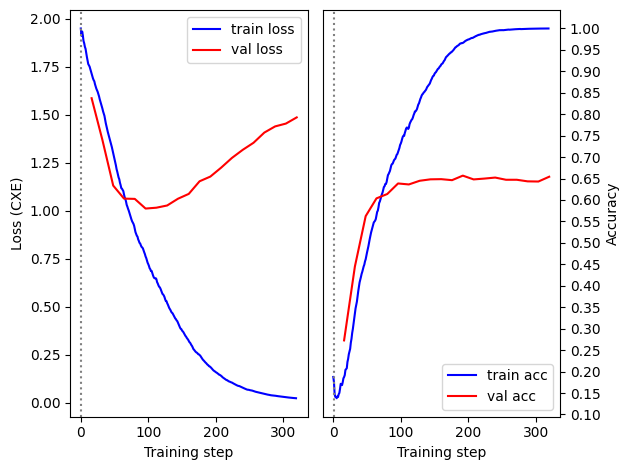

Layers finetuned:10/12
Fine-tuning with freeze depth: 2


epoch:19 | loss: 0.03|1.43, acc: 100%|64%: 100%|████████████████████| 20/20 [00:12<00:00,  1.58it/s]


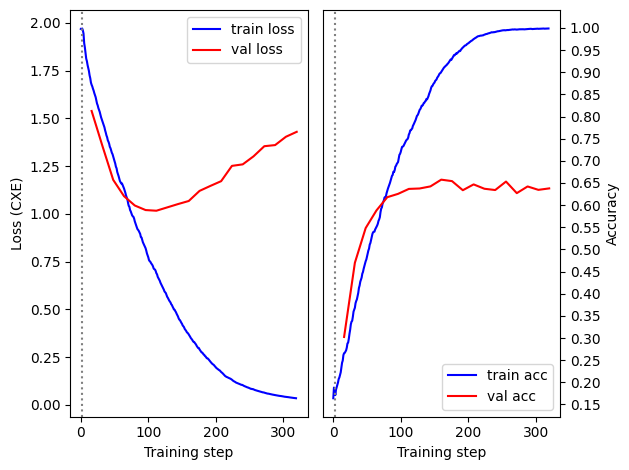

Layers finetuned:8/12
Fine-tuning with freeze depth: 3


epoch:19 | loss: 0.04|1.25, acc: 100%|63%: 100%|████████████████████| 20/20 [00:12<00:00,  1.63it/s]


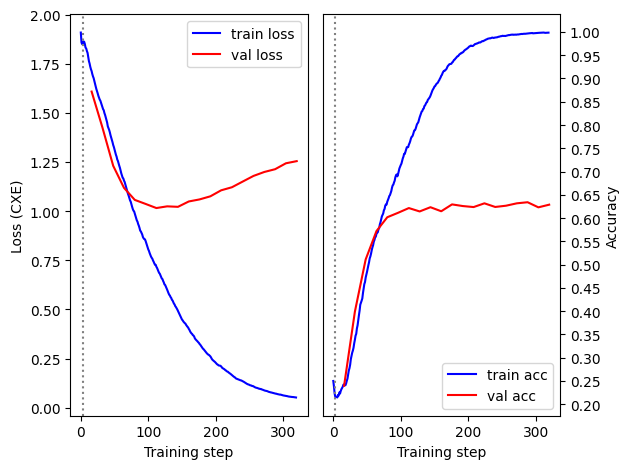

Layers finetuned:6/12
Fine-tuning with freeze depth: 4


epoch:19 | loss: 0.04|1.30, acc: 100%|61%: 100%|████████████████████| 20/20 [00:12<00:00,  1.62it/s]


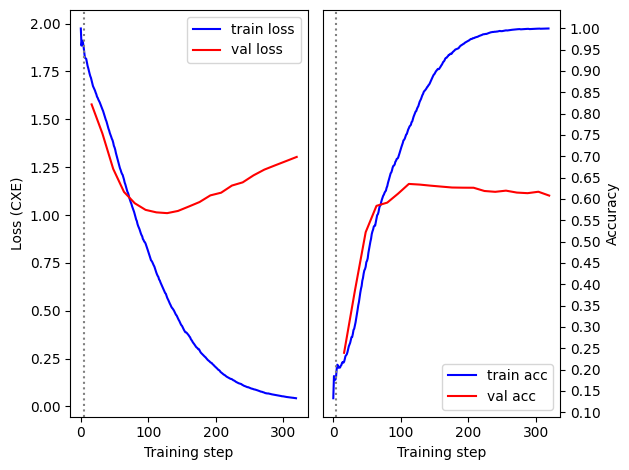

Layers finetuned:6/12
Fine-tuning with freeze depth: 5


epoch:19 | loss: 1.21|1.24, acc: 52%|51%: 100%|█████████████████████| 20/20 [00:12<00:00,  1.65it/s]


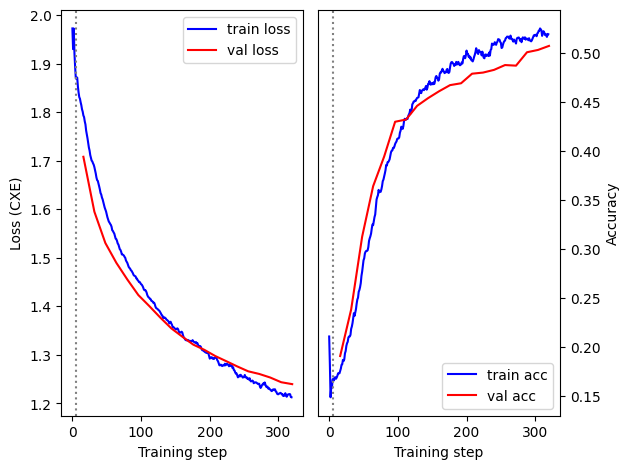

Layers finetuned:4/12
Fine-tuning with freeze depth: 6


epoch:19 | loss: 1.52|1.52, acc: 32%|32%: 100%|█████████████████████| 20/20 [00:11<00:00,  1.68it/s]


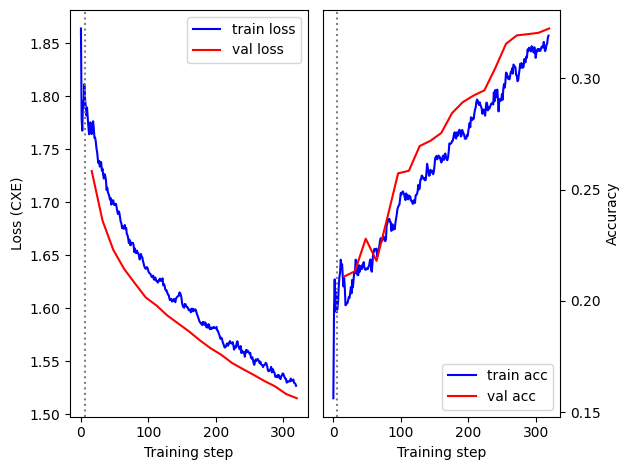

Layers finetuned:2/12
Fine-tuning with freeze depth: 7


epoch:19 | loss: 1.50|1.50, acc: 34%|35%: 100%|█████████████████████| 20/20 [00:12<00:00,  1.65it/s]


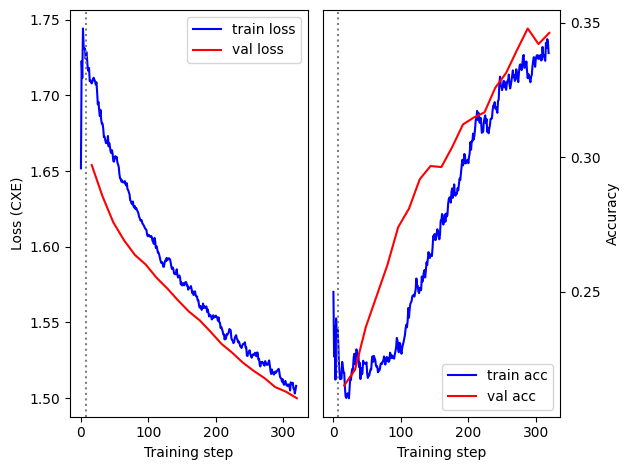

Layers finetuned:2/12


In [16]:
### run your experiment here
num_epochs = 30

# Fine-tuning with different freezing strategies
def freeze_layers_and_finetune(freeze_depth, ft_model, target_data, train_loader_target, val_loader_target, lr, l2_reg, num_epochs):
    # Freeze all layers except the classifier
    child_counter = 0
    for child in ft_model.children():
        if child_counter < freeze_depth:
            for param in child.parameters():
                param.requires_grad = False
        child_counter += 1

    ft_model.classifier = nn.Linear(256, target_data.num_classes).to(device)
    nn.init.kaiming_normal_(ft_model.classifier.weight)
    ft_model.classifier.bias.data.fill_(0.01)


    loss_func = nn.CrossEntropyLoss()
    ft_opt = torch.optim.Adam(ft_model.parameters(), lr=lr/10, weight_decay=l2_reg)


    train_losses, val_losses, train_accs, val_accs, epoch_steps = [], [], [], [], []
    metrics = [train_losses, val_losses, train_accs, val_accs, epoch_steps]

    epoch_bar = tqdm(range(num_epochs), ncols=100)
    steps_trained = 0
    for e in epoch_bar:
        ft_model.train()  # set training mode
        epoch_train_losses, epoch_train_accs = [], []
        for batch in train_loader_target:
            x, y = batch
            x, y = x.to(device), y.to(device)

            ft_opt.zero_grad()
            pred = ft_model(x)
            batch_loss = loss_func(pred, y)
            batch_acc = get_batch_acc(pred, y)

            batch_loss.backward()
            ft_opt.step()

            epoch_train_losses.append(batch_loss.item())
            epoch_train_accs.append(batch_acc)
            steps_trained += 1

        epoch_steps.append(steps_trained)

        train_losses.extend(epoch_train_losses)
        train_accs.extend(epoch_train_accs)

        # Evaluate
        with torch.no_grad():
            ft_model.eval()
            batch_val_losses, batch_val_accs = [], []
            for batch in val_loader_target:
                vx, vy = batch
                vx, vy = vx.to(device), vy.to(device)
                vpred = ft_model(vx)
                val_loss = loss_func(vpred, vy)
                val_acc = get_batch_acc(vpred, vy)

                batch_val_losses.append(val_loss.item())
                batch_val_accs.append(val_acc)
            val_losses.append(np.mean(batch_val_losses))
            val_accs.append(np.mean(batch_val_accs))

        epoch_bar.set_description(f'epoch:{e} | loss: {np.mean(epoch_train_losses):.2f}|{val_losses[-1]:.2f}, acc: {np.mean(epoch_train_accs):.0%}|{val_accs[-1]:.0%}')

    return metrics

# Loop through different freezing strategies
freeze_strategies = [0,1,2,3,4,5,6,7]
for freeze_depth in freeze_strategies:
    print(f'Fine-tuning with freeze depth: {freeze_depth}')
    ft_model = BasicCNN(num_classes=target_data.num_classes).to(device)

    # Load pre-trained weights
    pretrained_dict = torch.load('pretrained_model.pt')
    ft_model_dict = ft_model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in ft_model_dict and "classifier" not in k}
    ft_model_dict.update(pretrained_dict)
    ft_model.load_state_dict(ft_model_dict)

    # Fine-tune and track metrics
    metrics = freeze_layers_and_finetune(freeze_depth, ft_model, target_data, train_loader_target, val_loader_target, lr, l2_reg, num_epochs=20)

    # Plot the results for this freezing strategy
    training_plot(metrics, freeze_depth)

    #go back to all parameters require grad for next iteration
    layers_finetuned = 0
    for child in ft_model.children():
        for param in child.parameters():
            if param.requires_grad:
                layers_finetuned += 1
            param.requires_grad = True
    print("Layers finetuned:" + str(layers_finetuned) + "/12")

